In [138]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('seaborn-whitegrid')

import seaborn as sns
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import accuracy_score, f1_score
from sklearn.model_selection import KFold

from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LinearRegression, ElasticNet

from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from xgboost import XGBRegressor

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

import warnings
warnings.simplefilter('ignore')

In [139]:
ss = pd.read_csv('sample_submission.csv')
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [140]:
train["Day_of_2_Weeks"]=train["Day_No"]%14
test["Day_of_2_Weeks"]=test["Day_No"]%14

train.loc[train["Day_of_2_Weeks"]==0,"Day_of_2_Weeks"]=train.loc[train["Day_of_2_Weeks"]==0,"Day_of_2_Weeks"].apply(lambda x: x+14)
test.loc[test["Day_of_2_Weeks"]==0,"Day_of_2_Weeks"]=test.loc[test["Day_of_2_Weeks"]==0,"Day_of_2_Weeks"].apply(lambda x: x+14)

In [141]:
train["Week_No"]=np.ceil(train["Day_No"]/7)
train["Year_No"]=np.ceil(train["Week_No"]/52).astype('int')
train["Week_No"]=(train["Week_No"]%52).astype('int')

train.loc[train["Week_No"]==0,"Week_No"]=train.loc[train["Week_No"]==0,"Week_No"].apply(lambda x: x+52)

In [142]:
test["Week_No"]=np.ceil(test["Day_No"]/7)
test["Year_No"]=np.ceil(test["Week_No"]/52).astype('int')
test["Week_No"]=(test["Week_No"]%52).astype('int')

test.loc[test["Week_No"]==0,"Week_No"]=test.loc[test["Week_No"]==0,"Week_No"].apply(lambda x: x+52)

In [143]:
train.columns

Index(['ID', 'Day_No', 'Course_ID', 'Course_Domain', 'Course_Type',
       'Short_Promotion', 'Public_Holiday', 'Long_Promotion', 'User_Traffic',
       'Competition_Metric', 'Sales', 'Day_of_2_Weeks', 'Week_No', 'Year_No'],
      dtype='object')

In [144]:
# Imputing Missing Values

train.loc[(train["Course_ID"]==354) | (train["Course_ID"]==176),"Competition_Metric"]=train.groupby("Course_ID")["Competition_Metric"].mean().mean()
test.loc[(test["Course_ID"]==354) | (test["Course_ID"]==176),"Competition_Metric"]=train.groupby("Course_ID")["Competition_Metric"].mean().mean()

In [145]:
mean_by_course=train.groupby(["Course_ID","Week_No","Day_of_2_Weeks","Short_Promotion"])["Sales"].mean().to_frame()
mean_by_course.reset_index(inplace=True)
mean_by_course["Target_Course_ID"]=mean_by_course["Sales"]
mean_by_course.drop(columns="Sales",inplace=True)
mean_by_course

,Course_ID,Week_No,Day_of_2_Weeks,Short_Promotion,Target_Course_ID
0,1,1,1,0,72.666667
1,1,1,2,0,41.000000
2,1,1,3,0,48.666667
3,1,1,4,0,80.333333
4,1,1,5,0,49.000000
...,...,...,...,...,...
284815,600,52,10,0,67.500000
284816,600,52,11,0,71.500000
284817,600,52,12,0,126.000000
284818,600,52,13,0,17.500000


In [146]:
train=train.merge(mean_by_course)
test=test.merge(mean_by_course)

In [147]:
mean_UT=train.groupby(["Course_ID","Week_No","Short_Promotion","Day_of_2_Weeks"])["User_Traffic"].mean().to_frame()
mean_UT.reset_index(inplace=True)
mean_UT["Group_Traffic"]=mean_UT["User_Traffic"]
mean_UT.drop(columns="User_Traffic",inplace=True)
mean_UT

,Course_ID,Week_No,Short_Promotion,Day_of_2_Weeks,Group_Traffic
0,1,1,0,1,9968.0
1,1,1,0,2,6755.0
2,1,1,0,3,8022.0
3,1,1,0,4,11739.0
4,1,1,0,5,6965.0
...,...,...,...,...,...
284815,600,52,0,10,5880.0
284816,600,52,0,11,6132.0
284817,600,52,0,12,10342.5
284818,600,52,0,13,1995.0


In [148]:
train=train.merge(mean_UT)
test=test.merge(mean_UT)

In [149]:
test

,ID,Day_No,Course_ID,Course_Domain,Course_Type,Short_Promotion,Public_Holiday,Long_Promotion,Competition_Metric,Day_of_2_Weeks,Week_No,Year_No,Target_Course_ID,Group_Traffic
0,883,883,1,Development,Course,1,0,1,0.007,1,23,3,107.0,14175.0
1,884,884,1,Development,Course,1,0,1,0.007,2,23,3,123.0,17850.0
2,885,885,1,Development,Course,1,0,1,0.007,3,23,3,96.5,12988.5
3,886,886,1,Development,Course,1,0,1,0.007,4,23,3,93.0,12484.5
4,887,887,1,Development,Course,0,0,1,0.007,5,23,3,46.0,7245.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35995,548083,938,600,Software Marketing,Program,1,0,1,0.070,14,30,3,149.0,10993.5
35996,548084,939,600,Software Marketing,Program,1,0,1,0.070,1,31,3,129.0,9796.5
35997,548085,940,600,Software Marketing,Program,1,0,1,0.070,2,31,3,125.0,9576.0
35998,548086,941,600,Software Marketing,Program,1,0,1,0.070,3,31,3,124.0,9124.5


In [150]:
train.drop(columns=["ID","User_Traffic","Day_No","Course_ID"],inplace=True)
test.drop(columns=["ID","Day_No","Course_ID"],inplace=True)

In [154]:
ID_COL, TARGET_COL = 'ID', 'Sales'

num_cols = ['Competition_Metric']
cat_cols = ['Week_No', 'Course_Domain', 'Course_Type',
       'Short_Promotion', 'Public_Holiday', 'Long_Promotion']

In [155]:
def download_preds(preds_test, file_name = 'hacklive_sub.csv'):

  ## 1. Setting the target column with our obtained predictions
  ss[TARGET_COL] = preds_test

  ## 2. Saving our predictions to a csv file

  ss.to_csv(file_name, index = False)

In [156]:
train

,Course_Domain,Course_Type,Short_Promotion,Public_Holiday,Long_Promotion,Competition_Metric,Sales,Day_of_2_Weeks,Week_No,Year_No,Target_Course_ID,Group_Traffic
0,Development,Course,0,1,1,0.007,81,1,1,1,72.666667,9968.0
1,Development,Course,0,0,1,0.007,38,1,1,2,72.666667,9968.0
2,Development,Course,0,0,1,0.007,99,1,1,3,72.666667,9968.0
3,Development,Course,0,0,1,0.007,79,2,1,1,41.000000,6755.0
4,Development,Course,0,1,1,0.007,4,2,1,2,41.000000,6755.0
...,...,...,...,...,...,...,...,...,...,...,...,...
512082,Software Marketing,Program,1,0,1,0.070,144,14,4,3,144.000000,10164.0
512083,Software Marketing,Program,1,0,1,0.070,134,1,5,3,134.000000,9618.0
512084,Software Marketing,Program,1,0,1,0.070,130,2,5,3,130.000000,9807.0
512085,Software Marketing,Program,1,0,1,0.070,121,3,5,3,121.000000,9219.0


In [157]:
train.shape, test.shape

((512087, 12), (36000, 11))

In [158]:
df = pd.concat([train, test], axis=0).reset_index(drop = True)
df.shape

(548087, 12)

In [159]:
df.head()

,Course_Domain,Course_Type,Short_Promotion,Public_Holiday,Long_Promotion,Competition_Metric,Sales,Day_of_2_Weeks,Week_No,Year_No,Target_Course_ID,Group_Traffic
0,Development,Course,0,1,1,0.007,81.0,1,1,1,72.666667,9968.0
1,Development,Course,0,0,1,0.007,38.0,1,1,2,72.666667,9968.0
2,Development,Course,0,0,1,0.007,99.0,1,1,3,72.666667,9968.0
3,Development,Course,0,0,1,0.007,79.0,2,1,1,41.000000,6755.0
4,Development,Course,0,1,1,0.007,4.0,2,1,2,41.000000,6755.0


In [160]:
df.tail()

,Course_Domain,Course_Type,Short_Promotion,Public_Holiday,Long_Promotion,Competition_Metric,Sales,Day_of_2_Weeks,Week_No,Year_No,Target_Course_ID,Group_Traffic
548082,Software Marketing,Program,1,0,1,0.07,NaN,14,30,3,149.0,10993.5
548083,Software Marketing,Program,1,0,1,0.07,NaN,1,31,3,129.0,9796.5
548084,Software Marketing,Program,1,0,1,0.07,NaN,2,31,3,125.0,9576.0
548085,Software Marketing,Program,1,0,1,0.07,NaN,3,31,3,124.0,9124.5
548086,Software Marketing,Program,1,0,1,0.07,NaN,4,31,3,129.5,9481.5


In [161]:
df["Course_Domain"]=df["Course_Domain"].map({'Business':0,"Development":1,"Finance & Accounting":2,"Software Marketing":3})
df["Course_Type"]=df["Course_Type"].map({'Course':0,"Degree":1,"Program":2})

In [163]:
df.head(2)

,Course_Domain,Course_Type,Short_Promotion,Public_Holiday,Long_Promotion,Competition_Metric,Sales,Day_of_2_Weeks,Week_No,Year_No,Target_Course_ID,Group_Traffic
0,1,0,0,1,1,0.007,81.0,1,1,1,72.666667,9968.0
1,1,0,0,0,1,0.007,38.0,1,1,2,72.666667,9968.0


In [165]:
df[num_cols + ['Sales']] = df[num_cols + ['Sales']].apply(lambda x: np.log1p(x))

In [166]:
df['Sales']

0         4.406719
1         3.663562
2         4.605170
3         4.382027
4         1.609438
            ...   
548082         NaN
548083         NaN
548084         NaN
548085         NaN
548086         NaN
Name: Sales, Length: 548087, dtype: float64

In [167]:
train_proc, test_proc = df[:train.shape[0]], df[train.shape[0]:].reset_index(drop = True)
features = [c for c in train_proc.columns if c not in [ID_COL, TARGET_COL]]

In [168]:
train_proc.isnull().sum()

Course_Domain         0
Course_Type           0
Short_Promotion       0
Public_Holiday        0
Long_Promotion        0
Competition_Metric    0
Sales                 0
Day_of_2_Weeks        0
Week_No               0
Year_No               0
Target_Course_ID      0
Group_Traffic         0
dtype: int64

In [169]:
train_proc

,Course_Domain,Course_Type,Short_Promotion,Public_Holiday,Long_Promotion,Competition_Metric,Sales,Day_of_2_Weeks,Week_No,Year_No,Target_Course_ID,Group_Traffic
0,1,0,0,1,1,0.006976,4.406719,1,1,1,72.666667,9968.0
1,1,0,0,0,1,0.006976,3.663562,1,1,2,72.666667,9968.0
2,1,0,0,0,1,0.006976,4.605170,1,1,3,72.666667,9968.0
3,1,0,0,0,1,0.006976,4.382027,2,1,1,41.000000,6755.0
4,1,0,0,1,1,0.006976,1.609438,2,1,2,41.000000,6755.0
...,...,...,...,...,...,...,...,...,...,...,...,...
512082,3,2,1,0,1,0.067659,4.976734,14,4,3,144.000000,10164.0
512083,3,2,1,0,1,0.067659,4.905275,1,5,3,134.000000,9618.0
512084,3,2,1,0,1,0.067659,4.875197,2,5,3,130.000000,9807.0
512085,3,2,1,0,1,0.067659,4.804021,3,5,3,121.000000,9219.0


In [170]:
train_proc[train_proc.Week_No==1.0]

,Course_Domain,Course_Type,Short_Promotion,Public_Holiday,Long_Promotion,Competition_Metric,Sales,Day_of_2_Weeks,Week_No,Year_No,Target_Course_ID,Group_Traffic
0,1,0,0,1,1,0.006976,4.406719,1,1,1,72.666667,9968.0
1,1,0,0,0,1,0.006976,3.663562,1,1,2,72.666667,9968.0
2,1,0,0,0,1,0.006976,4.605170,1,1,3,72.666667,9968.0
3,1,0,0,0,1,0.006976,4.382027,2,1,1,41.000000,6755.0
4,1,0,0,1,1,0.006976,1.609438,2,1,2,41.000000,6755.0
...,...,...,...,...,...,...,...,...,...,...,...,...
511221,3,2,0,0,1,0.067659,4.174387,6,1,2,70.333333,6601.0
511222,3,2,0,0,1,0.067659,4.343805,6,1,3,70.333333,6601.0
511223,3,2,1,0,1,0.067659,4.828314,7,1,1,147.333333,11088.0
511224,3,2,1,0,1,0.067659,5.043425,7,1,2,147.333333,11088.0


In [171]:
trn, val = train_proc.iloc[:511926,],train_proc.iloc[511926:,]

###### Input to our model will be the features
X_trn, X_val = trn[features], val[features]

###### Output of our model will be the TARGET_COL
y_trn, y_val = trn[TARGET_COL], val[TARGET_COL]

##### Features for the test data that we will be predicting
X_test = test_proc[features]

In [172]:
from sklearn.metrics import mean_squared_error, mean_squared_log_error

def rmsle(y_true, y_pred):
  return np.sqrt(mean_squared_log_error(y_true, y_pred))

def av_metric(y_true, y_pred):
  return 1000 * np.sqrt(mean_squared_error(y_true, y_pred))

In [65]:
clf = LinearRegression()

_ = clf.fit(X_trn[num_cols], y_trn)

preds_val = clf.predict(X_val[num_cols])

av_metric_score = av_metric(y_val, preds_val)

print(f'AV metric score is: {av_metric_score}')

AV metric score is: 283.05333692349205


In [66]:
preds_test = clf.predict(X_test[num_cols])

preds_test = np.expm1(preds_test)

download_preds(preds_test, 'lr.csv')

In [96]:
pd.read_csv('lr.csv')

,ID,Sales
0,883,110.120619
1,884,110.120619
2,885,110.120619
3,886,110.120619
4,887,110.120619
...,...,...
35995,548083,109.500674
35996,548084,109.500674
35997,548085,109.500674
35998,548086,109.500674


In [97]:
X_trn.columns

Index(['Course_ID', 'Course_Domain', 'Course_Type', 'Short_Promotion',
       'Public_Holiday', 'Long_Promotion', 'Competition_Metric',
       'Day_of_2_Weeks', 'Week_No', 'Target_Course_ID', 'Group_Traffic'],
      dtype='object')

In [175]:
features = [c for c in X_trn.columns if c not in [ID_COL, TARGET_COL]]
cat_num_cols=features.copy()

In [176]:
features

['Course_Domain',
 'Course_Type',
 'Short_Promotion',
 'Public_Holiday',
 'Long_Promotion',
 'Competition_Metric',
 'Day_of_2_Weeks',
 'Week_No',
 'Year_No',
 'Target_Course_ID',
 'Group_Traffic']

In [76]:
def run_clf_kfold(clf, train, test, features):
  from sklearn.model_selection import StratifiedKFold
  N_SPLITS = 5

  oofs = np.zeros(len(train))
  preds = np.zeros((len(test)))

  target = train[TARGET_COL]

  folds = StratifiedKFold(n_splits = N_SPLITS)
  stratified_target = pd.qcut(train[TARGET_COL], 10, labels = False, duplicates='drop')

  for fold_, (trn_idx, val_idx) in enumerate(folds.split(train, stratified_target)):
    print(f'\n------------- Fold {fold_ + 1} -------------')

    ############# Get train, validation and test sets along with targets ################
  
    ### Training Set
    X_trn, y_trn = train[features].iloc[trn_idx], target.iloc[trn_idx]

    ### Validation Set
    X_val, y_val = train[features].iloc[val_idx], target.iloc[val_idx]

    ### Test Set
    X_test = test[features]

    ############# Scaling Data ################
    scaler = StandardScaler()
    _ = scaler.fit(X_trn)

    X_trn = scaler.transform(X_trn)
    X_val = scaler.transform(X_val)
    X_test = scaler.transform(X_test)


    ############# Fitting and Predicting ################

    _ = clf.fit(X_trn, y_trn)

    ### Instead of directly predicting the classes we will obtain the probability of positive class.
    preds_val = clf.predict(X_val)
    preds_test = clf.predict(X_test)

    fold_score = av_metric(y_val, preds_val)
    print(f'\nAV metric score for validation set is {fold_score}')

    oofs[val_idx] = preds_val
    preds += preds_test / N_SPLITS


  oofs_score = av_metric(target, oofs)
  print(f'\n\nAV metric for oofs is {oofs_score}')

  return oofs, preds

In [74]:
from lightgbm import LGBMRegressor

In [77]:
clf = LGBMRegressor()
lgb_oofs, lgb_preds = run_clf_kfold(clf, train_proc, test_proc, cat_num_cols)


------------- Fold 1 -------------

AV metric score for validation set is 129.53438358337445

------------- Fold 2 -------------

AV metric score for validation set is 98.3782628910615

------------- Fold 3 -------------

AV metric score for validation set is 103.55997949151335

------------- Fold 4 -------------

AV metric score for validation set is 100.4316011268039

------------- Fold 5 -------------

AV metric score for validation set is 147.68592448515233


AV metric for oofs is 117.54125728493179


In [78]:
lgb_preds_t = np.expm1(lgb_preds)
download_preds(lgb_preds_t, file_name = 'lgb_5_folds.csv')

In [177]:
def run_gradient_boosting(clf, fit_params, train, test, features):
  N_SPLITS = 5
  oofs = np.zeros(len(train_proc))
  preds = np.zeros((len(test_proc)))

  target = train[TARGET_COL]

  folds = StratifiedKFold(n_splits = N_SPLITS)
  stratified_target = pd.qcut(train[TARGET_COL], 10, labels = False, duplicates='drop')

  feature_importances = pd.DataFrame()

  for fold_, (trn_idx, val_idx) in enumerate(folds.split(train, stratified_target)):
    print(f'\n------------- Fold {fold_ + 1} -------------')

    ### Training Set
    X_trn, y_trn = train[features].iloc[trn_idx], target.iloc[trn_idx]

    ### Validation Set
    X_val, y_val = train[features].iloc[val_idx], target.iloc[val_idx]

    ### Test Set
    X_test = test[features]

    scaler = StandardScaler()
    _ = scaler.fit(X_trn)

    X_trn = scaler.transform(X_trn)
    X_val = scaler.transform(X_val)
    X_test = scaler.transform(X_test)
    
    _ = clf.fit(X_trn, y_trn, eval_set = [(X_val, y_val)], **fit_params)

    fold_importance = pd.DataFrame({'fold': fold_ + 1, 'feature': features, 'importance': clf.feature_importances_})
    feature_importances = pd.concat([feature_importances, fold_importance], axis=0)

    ### Instead of directly predicting the classes we will obtain the probability of positive class.
    preds_val = clf.predict(X_val)
    preds_test = clf.predict(X_test)

    fold_score = av_metric(y_val, preds_val)
    print(f'\nAV metric score for validation set is {fold_score}')

    oofs[val_idx] = preds_val
    preds += preds_test / N_SPLITS


  oofs_score = av_metric(target, oofs)
  print(f'\n\nAV metric for oofs is {oofs_score}')

  feature_importances = feature_importances.reset_index(drop = True)
  fi = feature_importances.groupby('feature')['importance'].mean().sort_values(ascending = False)[:20][::-1]
  fi.plot(kind = 'barh', figsize=(12, 6))

  return oofs, preds, fi


------------- Fold 1 -------------
[LightGBM] [Warning] Unknown parameter: base_score
[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_depth > num_leaves
Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 0.154903
Early stopping, best iteration is:
[25]	valid_0's rmse: 0.118926

AV metric score for validation set is 118.9255986820762

------------- Fold 2 -------------
[LightGBM] [Warning] Unknown parameter: base_score
[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_depth > num_leaves
Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 0.101814
[200]	valid_0's rmse: 0.0992869
[300]	valid_0's rmse: 0.0966145
[400]	valid_0's rmse: 0.0960635
[500]	valid_0's rmse: 0.0956539
[600]	valid_0's rmse: 0.0954253
Early stopping, best iteration is:
[572]	valid_0's rmse: 0.0953098

AV metric score for validation set is 95.3097552935526

------------- Fold 3 ---------

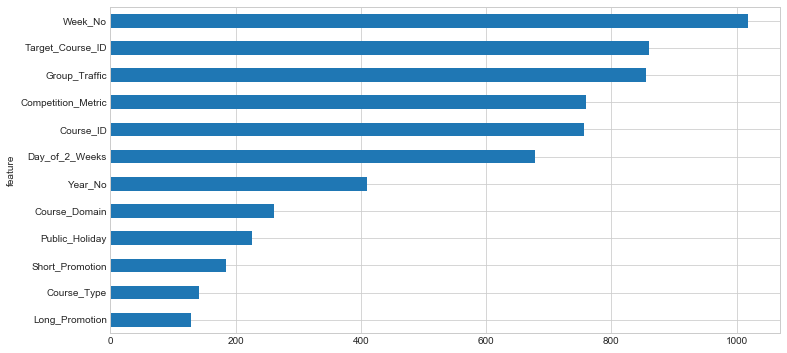

In [94]:
clf = LGBMRegressor(n_estimators = 1000,
                        learning_rate = 0.3,
                        colsample_bytree = 0.76,
                        metric = 'None',
                        subsample=0.7,
                        max_depth=9,
                        base_score=0.3
                    
                        )
fit_params = {'verbose': 100, 'early_stopping_rounds': 100, 'eval_metric': 'rmse'}

lgb_oofs, lgb_preds, fi = run_gradient_boosting(clf, fit_params, train_proc, test_proc, cat_num_cols)

In [95]:
lgb_preds_t = np.expm1(lgb_preds)
download_preds(lgb_preds_t, file_name = 'lgb_5_folds_tuned.csv')


------------- Fold 1 -------------
[LightGBM] [Warning] Unknown parameter: base_score
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[28]	valid_0's rmse: 0.117666

AV metric score for validation set is 117.66630953858309

------------- Fold 2 -------------
[LightGBM] [Warning] Unknown parameter: base_score
Training until validation scores don't improve for 200 rounds
[300]	valid_0's rmse: 0.0983679
Early stopping, best iteration is:
[187]	valid_0's rmse: 0.0941652

AV metric score for validation set is 94.16520814965908

------------- Fold 3 -------------
[LightGBM] [Warning] Unknown parameter: base_score
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[91]	valid_0's rmse: 0.105393

AV metric score for validation set is 105.39265627619076

------------- Fold 4 -------------
[LightGBM] [Warning] Unknown parameter: base_score
Training until validation scores don't improve for 200 rounds
[3

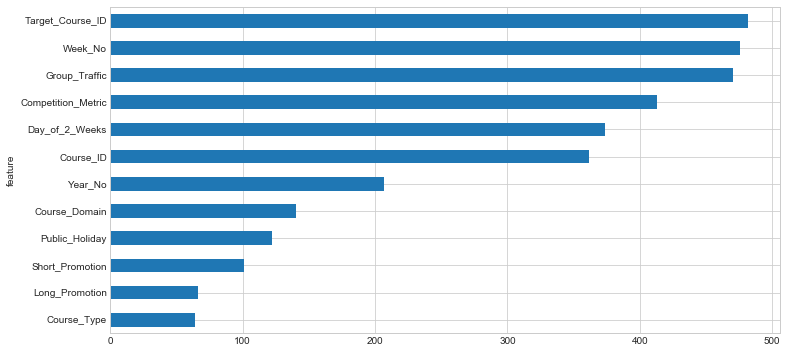

In [99]:
clf = LGBMRegressor(n_estimators = 5000,
                        learning_rate = 0.3,
                        colsample_bytree = 0.76,
                        metric = 'None',
                        subsample=0.7,
                        max_depth=9,
                        base_score=0.3,
                        num_leaves=50,
                        subsample_freq=2
                        )
fit_params = {'verbose': 300, 'early_stopping_rounds': 200, 'eval_metric': 'rmse'}

lgb_oofs, lgb_preds, fi = run_gradient_boosting(clf, fit_params, train_proc, test_proc, cat_num_cols)

In [92]:
lgb_preds_t = np.expm1(lgb_preds)
download_preds(lgb_preds_t, file_name = 'lgb_5_folds_tuned.csv')


------------- Fold 1 -------------
0:	learn: 0.4577598	test: 0.4573608	best: 0.4573608 (0)	total: 192ms	remaining: 9m 35s
200:	learn: 0.1757343	test: 0.1803465	best: 0.1803465 (200)	total: 10.4s	remaining: 2m 24s
400:	learn: 0.1401665	test: 0.1432208	best: 0.1432208 (400)	total: 20.5s	remaining: 2m 12s
600:	learn: 0.1315468	test: 0.1343240	best: 0.1343240 (600)	total: 30.5s	remaining: 2m 1s
800:	learn: 0.1265873	test: 0.1302934	best: 0.1302227 (796)	total: 40.5s	remaining: 1m 51s
1000:	learn: 0.1223948	test: 0.1275047	best: 0.1273232 (976)	total: 50.6s	remaining: 1m 40s
1200:	learn: 0.1187563	test: 0.1262652	best: 0.1259694 (1141)	total: 1m	remaining: 1m 30s
Stopped by overfitting detector  (200 iterations wait)

bestTest = 0.1259694235
bestIteration = 1141

Shrink model to first 1142 iterations.

AV metric score for validation set is 125.96942175318873

------------- Fold 2 -------------
0:	learn: 0.4574950	test: 0.4583575	best: 0.4583575 (0)	total: 49.3ms	remaining: 2m 27s
200:	lear

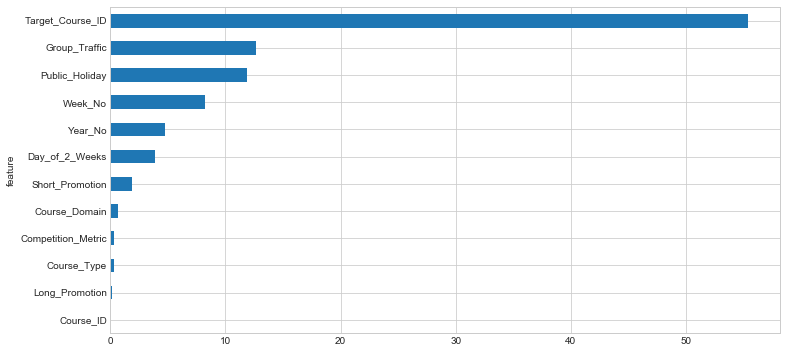

In [84]:
clf = CatBoostRegressor(n_estimators = 3000,
                       learning_rate = 0.01,
                       rsm = 0.4, ## Analogous to colsample_bytree
                       random_state=2054,
                       )

fit_params = {'verbose': 200, 'early_stopping_rounds': 200}

cb_oofs, cb_preds, fi = run_gradient_boosting(clf, fit_params, train_proc, test_proc, cat_num_cols)

**Submitting on the Leaderboard**

In [100]:
cb_preds_t = np.expm1(cb_preds)
download_preds(cb_preds_t, file_name = 'catbooost.csv')

In [86]:
pd.read_csv('catbooost.csv')

,ID,Sales
0,883,108.922377
1,884,125.669882
2,885,98.687966
3,886,95.482321
4,887,48.795178
...,...,...
35995,548083,156.085781
35996,548084,133.511358
35997,548085,130.112297
35998,548086,128.694644



------------- Fold 1 -------------
[0]	validation_0-rmse:3.11779
Will train until validation_0-rmse hasn't improved in 200 rounds.
[200]	validation_0-rmse:0.10709
[400]	validation_0-rmse:0.10690
Stopping. Best iteration:
[353]	validation_0-rmse:0.10661


AV metric score for validation set is 106.61012799858335

------------- Fold 2 -------------
[0]	validation_0-rmse:3.12234
Will train until validation_0-rmse hasn't improved in 200 rounds.
[200]	validation_0-rmse:0.10399
[400]	validation_0-rmse:0.10355
Stopping. Best iteration:
[351]	validation_0-rmse:0.10330


AV metric score for validation set is 103.30354146105465

------------- Fold 3 -------------
[0]	validation_0-rmse:3.11646
Will train until validation_0-rmse hasn't improved in 200 rounds.
[200]	validation_0-rmse:0.10564
[400]	validation_0-rmse:0.10561
Stopping. Best iteration:
[319]	validation_0-rmse:0.10518


AV metric score for validation set is 105.1834830785255

------------- Fold 4 -------------
[0]	validation_0-rmse:3.11

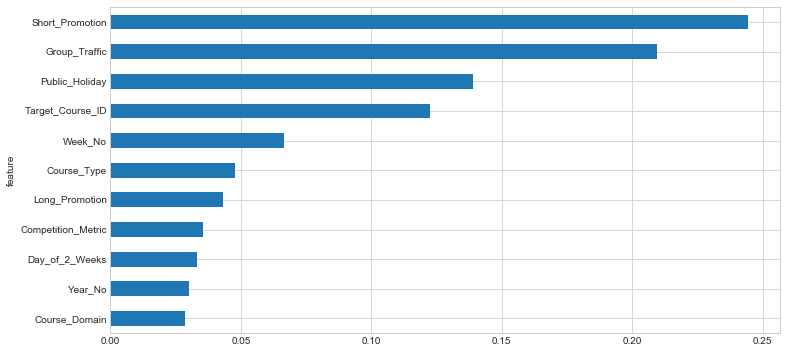

In [178]:
clf = XGBRegressor(n_estimators = 1000,
                    max_depth = 9,
                    learning_rate = 0.3,
                    colsample_bytree = 0.5,
                    random_state=1452,
                    subsample=0.7,
                    base_score=0.3
                    )

fit_params = {'verbose': 200, 'early_stopping_rounds': 200}

xgb_oofs, xgb_preds, fi = run_gradient_boosting(clf, fit_params, train_proc, test_proc, cat_num_cols)

In [102]:
len(xgb_oofs)

512087

In [179]:
xgb_preds_t = np.expm1(xgb_preds)
download_preds(xgb_preds_t, file_name = 'xgb_5_foldsn last.csv')

In [126]:
dt_oofs

array([4.60081305, 4.45861108, 4.45861108, ..., 4.86236984, 4.81401822,
       5.15120708])

In [127]:
lgb_oofs

array([4.36812031, 4.30778334, 4.30778334, ..., 4.82603677, 4.76877582,
       5.08197419])

In [130]:
cb_oofs

array([4.04476763, 4.26255736, 4.26255736, ..., 4.85872168, 4.79969452,
       5.10081679])

In [129]:
xgb_oofs

array([4.30459499, 4.34632397, 4.34632397, ..., 4.82434988, 4.76423407,
       5.07465982])

In [132]:
train_best=pd.DataFrame({"Decision_Tree":dt_oofs,"LGB":lgb_oofs,"Catboost":cb_oofs,"XGBoost":xgb_oofs})
train_best

,Decision_Tree,LGB,Catboost,XGBoost
0,4.600813,4.368120,4.044768,4.304595
1,4.458611,4.307783,4.262557,4.346324
2,4.458611,4.307783,4.262557,4.346324
3,3.821468,3.906250,3.958117,3.846191
4,1.957726,2.141115,2.458256,2.314983
...,...,...,...,...
512082,4.964031,4.915497,4.948457,4.888877
512083,4.910589,4.842187,4.877575,4.844403
512084,4.862370,4.826037,4.858722,4.824350
512085,4.814018,4.768776,4.799695,4.764234


In [136]:
train[TARGET_COL]

0          81
1          38
2          99
3          79
4           4
         ... 
512082    144
512083    134
512084    130
512085    121
512086    171
Name: Sales, Length: 512087, dtype: int64

In [133]:
test_best=pd.DataFrame({"Decision_Tree":dt_preds,"LGB":lgb_preds,"Catboost":cb_preds,"XGBoost":xgb_preds})
test_best

,Decision_Tree,LGB,Catboost,XGBoost
0,4.653284,4.670109,4.680468,4.674158
1,4.810320,4.816452,4.821795,4.810148
2,4.591309,4.576931,4.577591,4.579380
3,4.560603,4.546464,4.543853,4.546122
4,3.844450,3.885037,3.876080,3.887485
...,...,...,...,...
35995,5.038914,4.991761,4.997786,4.991538
35996,4.848754,4.840216,4.859434,4.841174
35997,4.819664,4.810635,4.824792,4.813676
35998,4.810320,4.795135,4.817732,4.795011


In [139]:
LR=LinearRegression()
LR.fit(train_best,np.log1p(train[TARGET_COL]))
predss=LR.predict(test_best)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [141]:
predsee = np.expm1(predss)
download_preds(predsee, file_name = 'Could Be Final.csv')